In [1]:
import os
import base64
from sqlalchemy import create_engine
import pymysql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/karan.verma")
from verification_guardrails import get_type_of_text

In [26]:
userid = 'Transcriber@transcription-prod'
passwd = 'TranscribePass1'
ipaddr = 'transcription-prod.mysql.database.azure.com'
db_name = 'speech_transcribe'
dest_sql = "mysql+mysqldb://" + userid + ":" + passwd + "@" + ipaddr + "/" + db_name + "?charset=utf8&use_unicode=0"
sql_engine = create_engine(dest_sql,pool_recycle=3600)
db_connection    = sql_engine.connect()


# Analysing Data Transcribe

In [4]:
data_from_transcribe = pd.read_sql('select * from data_transcribe where tag in (285,287,284) and verified in (1,8,11,7,17,18) and verified_time>="2020-08-01"', db_connection)
data_from_transcribe.describe()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,pre_processed,file_id,seq_id,test_data,lang,lang_lm,current_month_verification
count,1.876882e+06,1876882.0,1.876882e+06,1.876882e+06,1.876882e+06,1.876882e+06,1.876882e+06,1.876882e+06,1876882.0,1.876882e+06,1876882.0,1.876882e+06,1876882.0,1.876882e+06,1876882.0
mean,4.621846e+07,1.0,6.441652e+00,6.793765e+03,2.845628e+02,4.772495e+03,5.904340e+03,6.792321e-01,0.0,4.998827e+07,0.0,1.907738e-01,1.0,3.196791e-06,1.0
std,1.409002e+06,0.0,5.461582e+00,2.513581e+01,6.004347e-01,1.097431e+03,2.169082e+03,7.690335e-02,0.0,2.886731e+07,0.0,1.367971e+00,0.0,3.096832e-03,0.0
min,4.346808e+07,1.0,1.000000e+00,6.719000e+03,2.840000e+02,0.000000e+00,5.760000e+02,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0
25%,4.535800e+07,1.0,1.000000e+00,6.774000e+03,2.840000e+02,5.019000e+03,4.572000e+03,6.294950e-01,0.0,2.498995e+07,0.0,0.000000e+00,1.0,0.000000e+00,1.0
50%,4.627656e+07,1.0,7.000000e+00,6.789000e+03,2.850000e+02,5.042000e+03,5.112000e+03,6.872920e-01,0.0,4.997606e+07,0.0,0.000000e+00,1.0,0.000000e+00,1.0
75%,4.717176e+07,1.0,8.000000e+00,6.816000e+03,2.850000e+02,5.069000e+03,6.516000e+03,7.363650e-01,0.0,7.500621e+07,0.0,0.000000e+00,1.0,0.000000e+00,1.0
max,4.890668e+07,1.0,1.800000e+01,6.859000e+03,2.870000e+02,5.094000e+03,1.544400e+04,8.741070e-01,0.0,9.999974e+07,0.0,1.000000e+01,1.0,4.000000e+00,1.0


In [5]:
data_from_transcribe['corrected_utf_text_decoded'] = data_from_transcribe['corrected_utf_text'].apply(base64.urlsafe_b64decode).str.decode('utf8', errors='ignore').dropna()
data_from_transcribe['type_of_text'] = data_from_transcribe['corrected_utf_text_decoded'].apply(get_type_of_text)


In [6]:

data_from_transcribe['word_len'] = data_from_transcribe['corrected_utf_text_decoded'].str.split().apply(len)
data_from_transcribe.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,srv_session_id,corrected_utf_text_decoded,type_of_text,word_len
0,43541441,1,1,6815,284,5052,4572,0.746853,NaT,2020-09-28 13:43:18,...,0,0,1,0,b'NA',1,None,मास्क,0,1
1,43541443,1,7,6830,284,5081,5112,0.752223,NaT,2020-09-08 08:00:37,...,0,0,1,0,b'NA',1,None,@ _ @ गेम खेलने वाली मशीन,2,7
2,43541444,1,1,6815,284,5052,8424,0.667935,NaT,2020-09-28 13:43:18,...,0,0,1,0,b'NA',1,None,खिलौने वाली गाड़ी इसमें दो लोग बैठ सकते हैं असली,0,10
3,43541453,1,7,6831,284,5075,4284,0.748266,NaT,2020-08-17 17:39:13,...,0,0,1,0,b'NA',1,None,गर्ल्स शूज @ _ हाँ @,3,6
4,43541457,1,8,6785,284,5040,1512,0.874107,NaT,2020-09-07 12:51:34,...,0,0,1,0,b'NA',1,None,___,1,1


## Hours of Data for each type

### Primary Clean

In [6]:
data_from_transcribe_pri_clean =  data_from_transcribe[data_from_transcribe['type_of_text']==0]

data_from_transcribe_pri_clean_hr = data_from_transcribe_pri_clean["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_pri_clean_hr)


data_from_transcribe_pri_clean_count = data_from_transcribe_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_pri_clean_count)

data_from_transcribe_pri_clean_mean = data_from_transcribe_pri_clean["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_pri_clean_mean)

data_from_transcribe_pri_clean_mean_confidence = data_from_transcribe_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  1257.7506061111112
Total files                    :-  830955
Mean Audio Duration            :-  5449.034161898057
Mean Confidence                :-  0.6962580259532705


### Primary Underscore

In [9]:
data_from_transcribe_pri_underscore =  data_from_transcribe[data_from_transcribe['type_of_text']==1]

data_from_transcribe_pri_underscore_hr = data_from_transcribe_pri_underscore["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_pri_underscore_hr)


data_from_transcribe_pri_underscore_count = data_from_transcribe_pri_underscore["length"].count()
print("Total files                    :- ", data_from_transcribe_pri_underscore_count)

data_from_transcribe_pri_underscore_mean = data_from_transcribe_pri_underscore["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_pri_underscore_mean)

data_from_transcribe_pri_underscore_mean_confidence = data_from_transcribe_pri_underscore["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_pri_underscore_mean_confidence)


Total Audio Duration in hours  :-  219.85367027777778
Total files                    :-  154442
Mean Audio Duration            :-  5124.727813677627
Mean Confidence                :-  0.6718310598218102


### Secondary Non-prominent

In [7]:
data_from_transcribe_sec_non_prominent =  data_from_transcribe[data_from_transcribe['type_of_text']==2]

data_from_transcribe_sec_non_prominent_hr = data_from_transcribe_sec_non_prominent["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_sec_non_prominent_hr)


data_from_transcribe_sec_non_prominent_count = data_from_transcribe_sec_non_prominent["length"].count()
print("Total files                    :- ", data_from_transcribe_sec_non_prominent_count)

data_from_transcribe_sec_non_prominent_mean = data_from_transcribe_sec_non_prominent["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_sec_non_prominent_mean)

data_from_transcribe_sec_non_prominent_mean_confidence = data_from_transcribe_sec_non_prominent["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_sec_non_prominent_mean_confidence)


Total Audio Duration in hours  :-  981.8011191666667
Total files                    :-  592932
Mean Audio Duration            :-  5961.027620367934
Mean Confidence                :-  0.6750128445133675


### Secondary Prominent

In [12]:
data_from_transcribe_sec_prominent =  data_from_transcribe[data_from_transcribe['type_of_text']==3]

data_from_transcribe_sec_prominent_hr = data_from_transcribe_sec_prominent["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_sec_prominent_hr)


data_from_transcribe_sec_prominent_count = data_from_transcribe_sec_prominent["length"].count()
print("Total files                    :- ", data_from_transcribe_sec_prominent_count)

data_from_transcribe_sec_prominent_mean = data_from_transcribe_sec_prominent["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_sec_prominent_mean)

data_from_transcribe_sec_prominent_mean_confidence = data_from_transcribe_sec_prominent["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_sec_prominent_mean_confidence)


Total Audio Duration in hours  :-  505.6781755555556
Total files                    :-  235349
Mean Audio Duration            :-  7735.071880483877
Mean Confidence                :-  0.6326366802578299


### Total Data Transcribe

In [13]:
data_from_transcribe_hr = data_from_transcribe["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_hr)


data_from_transcribe_count = data_from_transcribe["length"].count()
print("Total files                    :- ", data_from_transcribe_count)

data_from_transcribe_mean = data_from_transcribe["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_mean)

data_from_transcribe_mean_confidence = data_from_transcribe["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_mean_confidence)


Total Audio Duration in hours  :-  2907.408215
Total files                    :-  1778273
Mean Audio Duration            :-  5885.862054926324
Mean Confidence                :-  0.6785795969240949


### Total Usable Data

In [8]:
data_from_transcribe_usable =  data_from_transcribe[(data_from_transcribe['type_of_text']==2) | (data_from_transcribe['type_of_text']==0) ]

data_from_transcribe_usable_hr = data_from_transcribe_usable["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_usable_hr)


data_from_transcribe_usable_count = data_from_transcribe_usable["length"].count()
print("Total files                    :- ", data_from_transcribe_usable_count)

data_from_transcribe_usable_mean = data_from_transcribe_usable["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_usable_mean)

data_from_transcribe_usable_mean_confidence = data_from_transcribe_usable["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_usable_mean_confidence)


Total Audio Duration in hours  :-  2305.954512222222
Total files                    :-  1464617
Mean Audio Duration            :-  5667.991184043337
Mean Confidence                :-  0.6877734277288873


# Word Length Distribution

## Primary Clean

<AxesSubplot:xlabel='word_len', ylabel='count'>

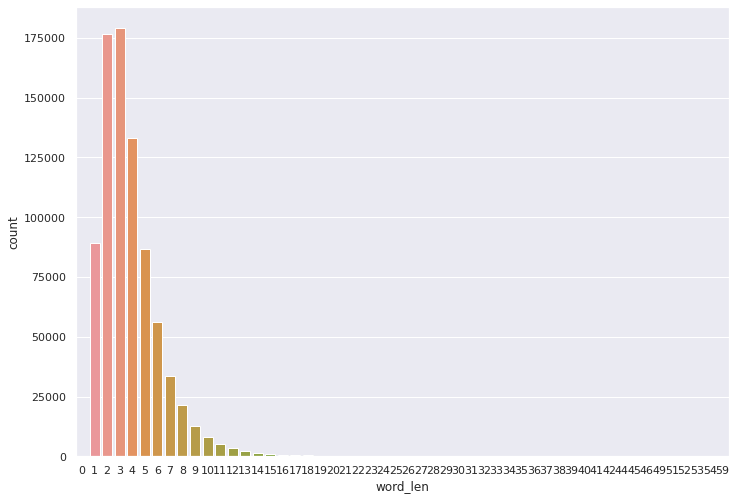

In [22]:
sns.countplot(x="word_len", data=data_from_transcribe_pri_clean)

## Primary Underscore

<AxesSubplot:xlabel='word_len', ylabel='count'>

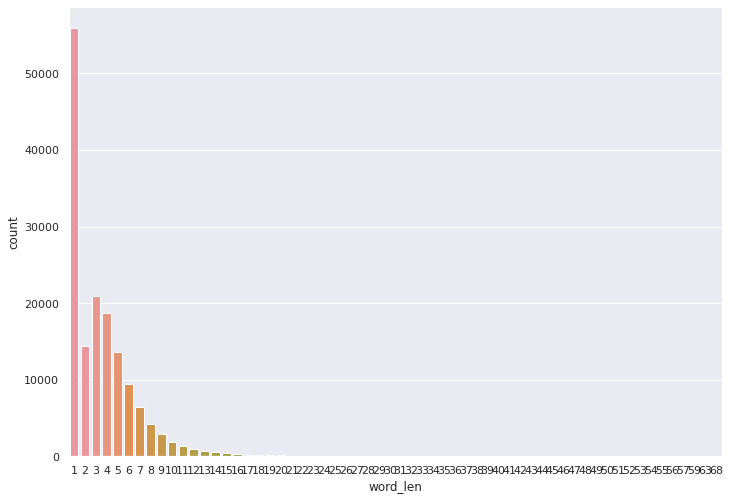

In [21]:
sns.countplot(x="word_len", data=data_from_transcribe_pri_underscore)

## Secondary Non-prominent

<AxesSubplot:xlabel='word_len', ylabel='count'>

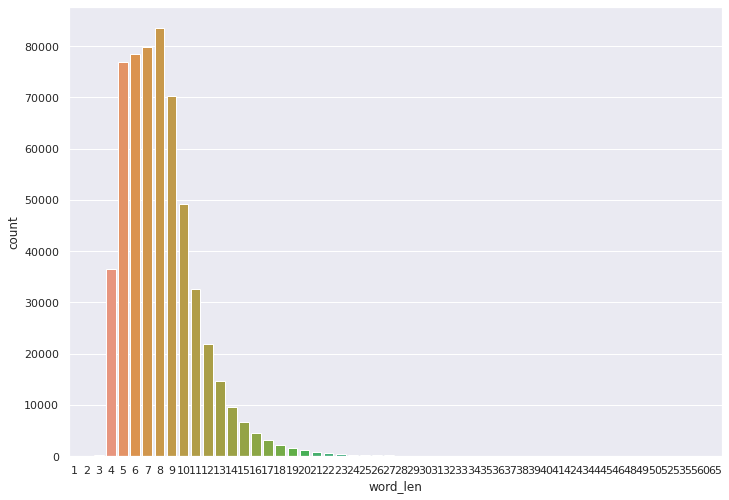

In [23]:
sns.countplot(x="word_len", data=data_from_transcribe_sec_non_prominent, saturation=0.75)

### Transcribe Usable

<AxesSubplot:xlabel='word_len', ylabel='count'>

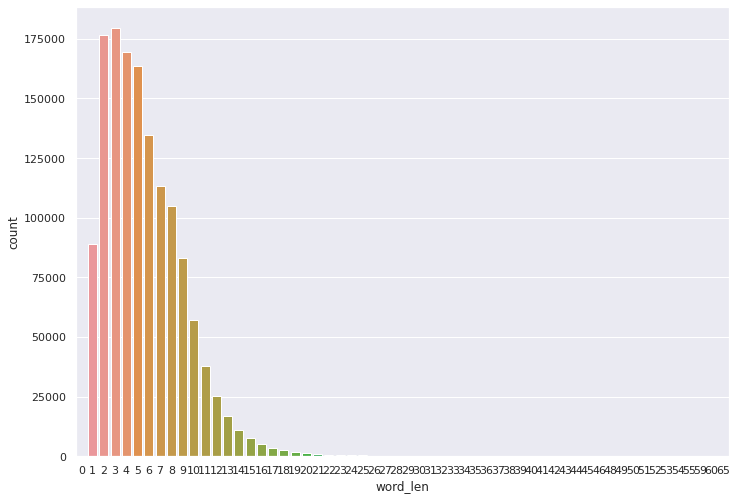

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("darkgrid")
sns.countplot(x="word_len", data=data_from_transcribe_usable)


# Data Previously Used

In [9]:
data_from_transcribe_prev = pd.read_sql('select * from vs_data_transcribe_till_27082020', db_connection)
data_from_transcribe_prev.describe()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,pre_processed,file_id,seq_id,test_data,lang,lang_lm,current_month_verification
count,1.254602e+06,1254602.0,1.254602e+06,1.254602e+06,1.254602e+06,1.254602e+06,1.254602e+06,1.254602e+06,1254602.0,1.254602e+06,1254602.0,1254602.0,1254602.0,1.254602e+06,1254602.0
mean,4.475609e+07,1.0,6.852188e+00,6.790784e+03,2.845590e+02,4.342123e+03,5.720621e+02,6.731662e-01,0.0,5.000666e+07,0.0,0.0,1.0,3.267969e-05,1.0
std,7.144373e+05,0.0,5.672051e+00,2.403095e+01,4.965062e-01,1.635739e+03,2.151857e+02,8.631590e-02,0.0,2.885173e+07,0.0,0.0,0.0,1.174272e-02,0.0
min,4.346835e+07,1.0,1.000000e+00,6.751000e+03,2.840000e+02,0.000000e+00,6.100000e+01,3.500060e-01,0.0,0.000000e+00,0.0,0.0,1.0,0.000000e+00,1.0
25%,4.418026e+07,1.0,1.000000e+00,6.770000e+03,2.840000e+02,5.009000e+03,4.570000e+02,6.185582e-01,0.0,2.501069e+07,0.0,0.0,1.0,0.000000e+00,1.0
50%,4.473223e+07,1.0,7.000000e+00,6.787000e+03,2.850000e+02,5.038000e+03,5.080000e+02,6.782630e-01,0.0,4.999629e+07,0.0,0.0,1.0,0.000000e+00,1.0
75%,4.536528e+07,1.0,8.000000e+00,6.813000e+03,2.850000e+02,5.062000e+03,6.440000e+02,7.324680e-01,0.0,7.497523e+07,0.0,0.0,1.0,0.000000e+00,1.0
max,4.609752e+07,1.0,1.800000e+01,6.839000e+03,2.850000e+02,5.088000e+03,1.544000e+03,8.741070e-01,0.0,9.999974e+07,0.0,0.0,1.0,8.000000e+00,1.0


In [10]:
data_from_transcribe_prev['corrected_utf_text_decoded'] = data_from_transcribe_prev['corrected_utf_text'].apply(base64.urlsafe_b64decode).str.decode('utf8', errors='ignore').dropna()
data_from_transcribe_prev['type_of_text'] = data_from_transcribe_prev['corrected_utf_text_decoded'].apply(get_type_of_text)
data_from_transcribe_prev['word_len'] = data_from_transcribe_prev['corrected_utf_text_decoded'].str.split().apply(len)
data_from_transcribe_prev.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
0,43471664,1,1,6835,284,5010,644,0.694978,None,2020-07-14 15:05:21,...,67042816,0,0,1,0,b'NA',1,विमेन रनिंग शूज़,0,3
1,43471679,1,18,6835,284,5010,598,0.642685,None,2020-07-14 15:05:21,...,97002752,0,0,1,0,b'NA',1,@ _ @ मैगना आई टेन @ _ @ हॉर्न @ _ @,2,13
2,43471681,1,18,6835,284,5010,598,0.607033,None,2020-07-14 15:05:21,...,21612032,0,0,1,0,b'NA',1,@ _ @ मैगना आई टेन हॉर्न @ _ @,2,10
3,43471686,1,1,6835,284,5010,464,0.748978,None,2020-07-14 15:05:21,...,25775104,0,0,1,0,b'NA',1,सैमसंग फ़ोन्स,0,2
4,43471690,1,8,6751,284,800,547,0.692100,None,2020-06-09 16:07:42,...,53777408,0,0,1,0,b'NA',1,फाइव स्टार ए सी,0,4


## Prev Clean Data 

In [11]:
data_from_transcribe_prev_pri_clean =  data_from_transcribe_prev[data_from_transcribe_prev['type_of_text']==0]

data_from_transcribe_prev_pri_clean_hr = data_from_transcribe_prev_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_pri_clean_hr)


data_from_transcribe_prev_pri_clean_count = data_from_transcribe_prev_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_pri_clean_count)

data_from_transcribe_prev_pri_clean_mean = data_from_transcribe_prev_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_pri_clean_mean)

data_from_transcribe_prev_pri_clean_mean_confidence = data_from_transcribe_prev_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  868.4401
Total files                    :-  580817
Mean Audio Duration            :-  5382.735629294597
Mean Confidence                :-  0.6902117915264188


## Prev Non Prom Secondary

In [14]:
data_from_transcribe_prev_pri_clean =  data_from_transcribe_prev[data_from_transcribe_prev['type_of_text']==2]

data_from_transcribe_prev_pri_clean_hr = data_from_transcribe_prev_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_pri_clean_hr)


data_from_transcribe_prev_pri_clean_count = data_from_transcribe_prev_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_pri_clean_count)

data_from_transcribe_prev_pri_clean_mean = data_from_transcribe_prev_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_pri_clean_mean)

data_from_transcribe_prev_pri_clean_mean_confidence = data_from_transcribe_prev_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  637.5470388888889
Total files                    :-  391988
Mean Audio Duration            :-  5855.20306744084
Mean Confidence                :-  0.6646118832209148


In [ ]:
data_from_transcribe_prev.head()

In [ ]:
## t0 - 1aug
## non-overlapping
## 1 aug - 27 aug

## Analysis of Overlapping Data

In [3]:
data_from_transcribe_prev_overlap = pd.read_sql('select * from vs_data_transcribe_till_27082020 where verified_time>="2020-08-01"', db_connection)
data_from_transcribe_prev_overlap.describe()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,pre_processed,file_id,seq_id,test_data,lang,lang_lm,current_month_verification
count,6.145580e+05,614558.0,614558.000000,614558.000000,614558.000000,614558.000000,614558.000000,614558.000000,614558.0,6.145580e+05,614558.0,614558.0,614558.0,614558.000000,614558.0
mean,4.507148e+07,1.0,6.878179,6791.976168,284.538273,4729.498565,572.655735,0.673200,0.0,4.999114e+07,0.0,0.0,1.0,0.000002,1.0
std,7.664817e+05,0.0,5.662247,23.655645,0.498533,1158.117377,210.981882,0.080799,0.0,2.886030e+07,0.0,0.0,0.0,0.001276,0.0
min,4.346836e+07,1.0,1.000000,6751.000000,284.000000,0.000000,61.000000,0.350062,0.0,0.000000e+00,0.0,0.0,1.0,0.000000,1.0
25%,4.424247e+07,1.0,1.000000,6773.000000,284.000000,5016.000000,457.000000,0.620785,0.0,2.497146e+07,0.0,0.0,1.0,0.000000,1.0
50%,4.537844e+07,1.0,7.000000,6788.000000,285.000000,5041.000000,508.000000,0.678785,0.0,4.999040e+07,0.0,0.0,1.0,0.000000,1.0
75%,4.567351e+07,1.0,8.000000,6813.000000,285.000000,5066.000000,652.000000,0.730819,0.0,7.497773e+07,0.0,0.0,1.0,0.000000,1.0
max,4.609752e+07,1.0,18.000000,6839.000000,285.000000,5088.000000,1544.000000,0.874107,0.0,9.999974e+07,0.0,0.0,1.0,1.000000,1.0


In [4]:
data_from_transcribe_prev_overlap['corrected_utf_text_decoded'] = data_from_transcribe_prev_overlap['corrected_utf_text'].apply(base64.urlsafe_b64decode).str.decode('utf8', errors='ignore').dropna()
data_from_transcribe_prev_overlap['type_of_text'] = data_from_transcribe_prev_overlap['corrected_utf_text_decoded'].apply(get_type_of_text)
data_from_transcribe_prev_overlap['word_len'] = data_from_transcribe_prev_overlap['corrected_utf_text_decoded'].str.split().apply(len)
data_from_transcribe_prev_overlap.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
0,43541453,1,7,6831,284,5075,428,0.748266,None,2020-08-17 17:39:13,...,61931264,0,0,1,0,b'NA',1,गर्ल्स शूज @ _ हाँ @,3,6
1,43541481,1,8,6831,284,5075,745,0.738535,None,2020-08-17 17:39:13,...,31844352,0,0,1,0,b'NA',1,ट्वेल्व इयर्स गर्ल्स शूज,0,4
2,43541500,1,1,6831,284,5075,151,0.874107,None,2020-08-17 17:39:13,...,15264512,0,0,1,0,b'NA',1,___,1,1
3,43541502,1,8,6831,284,5075,104,0.874107,None,2020-08-17 17:39:13,...,80063488,0,0,1,0,b'NA',1,___,1,1
4,43541513,1,1,6831,284,5075,457,0.576912,None,2020-08-17 17:39:13,...,70206976,0,0,1,0,b'NA',1,वॉच रेनी डे,0,3


## Clean Data (Overlapping)

In [17]:
data_from_transcribe_prev_overlap_pri_clean =  data_from_transcribe_prev_overlap[data_from_transcribe_prev_overlap['type_of_text']==0]

data_from_transcribe_prev_overlap_pri_clean_hr = data_from_transcribe_prev_overlap_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_overlap_pri_clean_hr)


data_from_transcribe_prev_overlap_pri_clean_count = data_from_transcribe_prev_overlap_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_overlap_pri_clean_count)

data_from_transcribe_prev_overlap_pri_clean_mean = data_from_transcribe_prev_overlap_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_overlap_pri_clean_mean)

data_from_transcribe_prev_overlap_pri_clean_mean_confidence = data_from_transcribe_prev_overlap_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_overlap_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  425.8856333333333
Total files                    :-  284685
Mean Audio Duration            :-  5385.56046156278
Mean Confidence                :-  0.6906264207351984


## Sec Non-Prominent (Overlapping)

In [18]:
data_from_transcribe_prev_overlap_pri_clean =  data_from_transcribe_prev_overlap[data_from_transcribe_prev_overlap['type_of_text']==2]

data_from_transcribe_prev_overlap_pri_clean_hr = data_from_transcribe_prev_overlap_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_overlap_pri_clean_hr)


data_from_transcribe_prev_overlap_pri_clean_count = data_from_transcribe_prev_overlap_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_overlap_pri_clean_count)

data_from_transcribe_prev_overlap_pri_clean_mean = data_from_transcribe_prev_overlap_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_overlap_pri_clean_mean)

data_from_transcribe_prev_overlap_pri_clean_mean_confidence = data_from_transcribe_prev_overlap_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_overlap_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  311.29191388888887
Total files                    :-  192613
Mean Audio Duration            :-  5818.14773665329
Mean Confidence                :-  0.66705300132909


# Pre Aug 1 for vs_27 experiment

In [19]:
data_from_transcribe_prev_overlap_0 = pd.read_sql('select * from vs_data_transcribe_till_27082020 where verified_time<"2020-08-01"', db_connection)
data_from_transcribe_prev_overlap_0.describe()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,pre_processed,file_id,seq_id,test_data,lang,lang_lm,current_month_verification
count,6.400440e+05,640044.0,640044.000000,640044.000000,640044.000000,640044.000000,640044.000000,640044.000000,640044.0,6.400440e+05,640044.0,640044.0,640044.0,640044.000000,640044.0
mean,4.445326e+07,1.0,6.827232,6789.639956,284.578915,3970.172796,571.492054,0.673134,0.0,5.002156e+07,0.0,0.0,1.0,0.000062,1.0
std,4.992018e+05,0.0,5.681343,24.331006,0.493734,1916.894808,219.144922,0.091300,0.0,2.884351e+07,0.0,0.0,0.0,0.016393,0.0
min,4.346835e+07,1.0,1.000000,6751.000000,284.000000,0.000000,76.000000,0.350006,0.0,0.000000e+00,0.0,0.0,1.0,0.000000,1.0
25%,4.407866e+07,1.0,1.000000,6768.000000,284.000000,5004.000000,457.000000,0.616351,0.0,2.505005e+07,0.0,0.0,1.0,0.000000,1.0
50%,4.450167e+07,1.0,7.000000,6787.000000,285.000000,5029.000000,508.000000,0.677742,0.0,5.000448e+07,0.0,0.0,1.0,0.000000,1.0
75%,4.487743e+07,1.0,8.000000,6812.000000,285.000000,5059.000000,644.000000,0.734261,0.0,7.497139e+07,0.0,0.0,1.0,0.000000,1.0
max,4.522304e+07,1.0,18.000000,6839.000000,285.000000,5088.000000,1544.000000,0.874107,0.0,9.999974e+07,0.0,0.0,1.0,8.000000,1.0


In [20]:
data_from_transcribe_prev_overlap_0['corrected_utf_text_decoded'] = data_from_transcribe_prev_overlap_0['corrected_utf_text'].apply(base64.urlsafe_b64decode).str.decode('utf8', errors='ignore').dropna()
data_from_transcribe_prev_overlap_0['type_of_text'] = data_from_transcribe_prev_overlap_0['corrected_utf_text_decoded'].apply(get_type_of_text)
data_from_transcribe_prev_overlap_0['word_len'] = data_from_transcribe_prev_overlap_0['corrected_utf_text_decoded'].str.split().apply(len)
data_from_transcribe_prev_overlap_0.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
0,43471664,1,1,6835,284,5010,644,0.694978,None,2020-07-14 15:05:21,...,67042816,0,0,1,0,b'NA',1,विमेन रनिंग शूज़,0,3
1,43471679,1,18,6835,284,5010,598,0.642685,None,2020-07-14 15:05:21,...,97002752,0,0,1,0,b'NA',1,@ _ @ मैगना आई टेन @ _ @ हॉर्न @ _ @,2,13
2,43471681,1,18,6835,284,5010,598,0.607033,None,2020-07-14 15:05:21,...,21612032,0,0,1,0,b'NA',1,@ _ @ मैगना आई टेन हॉर्न @ _ @,2,10
3,43471686,1,1,6835,284,5010,464,0.748978,None,2020-07-14 15:05:21,...,25775104,0,0,1,0,b'NA',1,सैमसंग फ़ोन्स,0,2
4,43471690,1,8,6751,284,800,547,0.692100,None,2020-06-09 16:07:42,...,53777408,0,0,1,0,b'NA',1,फाइव स्टार ए सी,0,4


### Pre Aug1 Clean

In [21]:
data_from_transcribe_prev_overlap_0_pri_clean =  data_from_transcribe_prev_overlap_0[data_from_transcribe_prev_overlap_0['type_of_text']==0]

data_from_transcribe_prev_overlap_0_pri_clean_hr = data_from_transcribe_prev_overlap_0_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_overlap_0_pri_clean_hr)


data_from_transcribe_prev_overlap_0_pri_clean_count = data_from_transcribe_prev_overlap_0_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_overlap_0_pri_clean_count)

data_from_transcribe_prev_overlap_0_pri_clean_mean = data_from_transcribe_prev_overlap_0_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_overlap_0_pri_clean_mean)

data_from_transcribe_prev_overlap_0_pri_clean_mean_confidence = data_from_transcribe_prev_overlap_0_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_overlap_0_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  442.55446666666666
Total files                    :-  296132
Mean Audio Duration            :-  5380.019991085056
Mean Confidence                :-  0.6898131898342632


### Pre AUg1 Sec Non-prom

In [22]:
data_from_transcribe_prev_overlap_0_pri_clean =  data_from_transcribe_prev_overlap_0[data_from_transcribe_prev_overlap_0['type_of_text']==2]

data_from_transcribe_prev_overlap_0_pri_clean_hr = data_from_transcribe_prev_overlap_0_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_overlap_0_pri_clean_hr)


data_from_transcribe_prev_overlap_0_pri_clean_count = data_from_transcribe_prev_overlap_0_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_overlap_0_pri_clean_count)

data_from_transcribe_prev_overlap_0_pri_clean_mean = data_from_transcribe_prev_overlap_0_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_overlap_0_pri_clean_mean)

data_from_transcribe_prev_overlap_0_pri_clean_mean_confidence = data_from_transcribe_prev_overlap_0_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_overlap_0_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  326.255125
Total files                    :-  199375
Mean Audio Duration            :-  5891.001630094043
Mean Confidence                :-  0.6622535580438871


### Pre Aug 1 Total Usable

In [33]:
data_from_transcribe_prev_overlap_0_pri_clean =  data_from_transcribe_prev_overlap_0[(data_from_transcribe_prev_overlap_0['type_of_text']==2) | (data_from_transcribe_prev_overlap_0['type_of_text']==0)]

data_from_transcribe_prev_overlap_0_pri_clean_hr = data_from_transcribe_prev_overlap_0_pri_clean["length"].sum()/(60*100*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_prev_overlap_0_pri_clean_hr)


data_from_transcribe_prev_overlap_0_pri_clean_count = data_from_transcribe_prev_overlap_0_pri_clean["length"].count()
print("Total files                    :- ", data_from_transcribe_prev_overlap_0_pri_clean_count)

data_from_transcribe_prev_overlap_0_pri_clean_mean = data_from_transcribe_prev_overlap_0_pri_clean["length"].mean()*10
print("Mean Audio Duration            :- ", data_from_transcribe_prev_overlap_0_pri_clean_mean)

data_from_transcribe_prev_overlap_0_pri_clean_mean_confidence = data_from_transcribe_prev_overlap_0_pri_clean["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_prev_overlap_0_pri_clean_mean_confidence)


Total Audio Duration in hours  :-  768.8095916666666
Total files                    :-  495507
Mean Audio Duration            :-  5585.62145438914
Mean Confidence                :-  0.6787241404601752


## Re-verfication

In [23]:
data_from_transcribe_prev.text_id.max()

46097518

In [24]:
data_from_transcribe_ver = pd.read_sql('select * from data_transcribe where tag in (285,287,284) and verified in (1,8,11,7,17,18) and verified_time>="2020-08-01" and text_id>46097518', db_connection)
data_from_transcribe_ver.describe()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,pre_processed,file_id,seq_id,test_data,lang,lang_lm,current_month_verification
count,9.771380e+05,977138.0,977138.000000,977138.000000,977138.000000,977138.000000,977138.000000,977138.000000,977138.0,9.771380e+05,977138.0,977138.000000,977138.0,977138.000000,977138.0
mean,4.718888e+07,1.0,6.328047,6794.859695,284.556094,4813.650392,6045.519798,0.683735,0.0,4.998948e+07,0.0,0.225495,1.0,0.000005,1.0
std,7.428912e+05,0.0,5.367600,24.759175,0.618184,1025.126708,2164.899645,0.067833,0.0,2.887910e+07,0.0,1.484623,0.0,0.004171,0.0
min,4.609752e+07,1.0,1.000000,6751.000000,284.000000,0.000000,936.000000,0.000000,0.0,0.000000e+00,0.0,0.000000,1.0,0.000000,1.0
25%,4.657930e+07,1.0,1.000000,6775.000000,284.000000,5019.000000,4572.000000,0.637354,0.0,2.498842e+07,0.0,0.000000,1.0,0.000000,1.0
50%,4.701866e+07,1.0,7.000000,6789.000000,285.000000,5042.000000,5184.000000,0.693072,0.0,4.997606e+07,0.0,0.000000,1.0,0.000000,1.0
75%,4.782694e+07,1.0,8.000000,6817.000000,285.000000,5070.000000,6552.000000,0.738412,0.0,7.503194e+07,0.0,0.000000,1.0,0.000000,1.0
max,4.867420e+07,1.0,18.000000,6859.000000,287.000000,5094.000000,15444.000000,0.874107,0.0,9.999974e+07,0.0,10.000000,1.0,4.000000,1.0


In [25]:
data_from_transcribe_ver['corrected_utf_text_decoded'] = data_from_transcribe_ver['corrected_utf_text'].apply(base64.urlsafe_b64decode).str.decode('utf8', errors='ignore').dropna()
data_from_transcribe_ver['type_of_text'] = data_from_transcribe_ver['corrected_utf_text_decoded'].apply(get_type_of_text)
data_from_transcribe_ver['word_len'] = data_from_transcribe_ver['corrected_utf_text_decoded'].str.split().apply(len)
data_from_transcribe_ver.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,srv_session_id,corrected_utf_text_decoded,type_of_text,word_len
0,46097523,1,1,6842,287,169,1044,0.797167,2020-08-26 15:21:44,2020-08-27 12:56:55,...,0,10,1,0,b'NA',1,None,___,1,1
1,46097528,1,1,6840,287,5073,1044,0.658277,2020-08-26 15:21:51,2020-08-27 08:35:46,...,0,10,1,0,b'NA',1,None,_,1,1
2,46097536,1,7,6842,287,169,2016,0.700801,2020-08-26 15:21:59,2020-08-27 12:56:55,...,0,10,1,0,b'NA',1,None,@ _ @ वीवो फोन दस हजार,2,7
3,46097540,1,7,6840,287,5073,6084,0.717133,2020-08-26 15:21:42,2020-08-27 08:35:46,...,0,10,1,0,b'NA',1,None,@ _ @ कॉटन का ब्लाउज सिला हुआ @ _ @,2,11
4,46097543,1,1,6840,287,5073,3924,0.813452,2020-08-26 15:21:47,2020-08-27 08:26:48,...,0,10,1,0,b'NA',1,None,नाइट सनग्लासेस,0,2


In [26]:
data_from_transcribe_ver_usable =  data_from_transcribe_ver[(data_from_transcribe_ver['type_of_text']==0) ]

data_from_transcribe_ver_usable_hr = data_from_transcribe_ver_usable["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_ver_usable_hr)


data_from_transcribe_ver_usable_count = data_from_transcribe_ver_usable["length"].count()
print("Total files                    :- ", data_from_transcribe_ver_usable_count)

data_from_transcribe_ver_usable_mean = data_from_transcribe_ver_usable["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_ver_usable_mean)

data_from_transcribe_ver_usable_mean_confidence = data_from_transcribe_ver_usable["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_ver_usable_mean_confidence)


Total Audio Duration in hours  :-  668.3330052777778
Total files                    :-  437061
Mean Audio Duration            :-  5504.949695809052
Mean Confidence                :-  0.7012286761779246


In [27]:
data_from_transcribe_ver_usable =  data_from_transcribe_ver[(data_from_transcribe_ver['type_of_text']==2) ]

data_from_transcribe_ver_usable_hr = data_from_transcribe_ver_usable["length"].sum()/(60*1000*60)
print("Total Audio Duration in hours  :- ", data_from_transcribe_ver_usable_hr)


data_from_transcribe_ver_usable_count = data_from_transcribe_ver_usable["length"].count()
print("Total files                    :- ", data_from_transcribe_ver_usable_count)

data_from_transcribe_ver_usable_mean = data_from_transcribe_ver_usable["length"].mean()
print("Mean Audio Duration            :- ", data_from_transcribe_ver_usable_mean)

data_from_transcribe_ver_usable_mean_confidence = data_from_transcribe_ver_usable["confidence"].mean()
print("Mean Confidence                :- ", data_from_transcribe_ver_usable_mean_confidence)


Total Audio Duration in hours  :-  559.9044294444444
Total files                    :-  332954
Mean Audio Duration            :-  6053.857127410994
Mean Confidence                :-  0.6828656990845582


# Repeated Table

In [5]:
data_from_transcribe_prev_overlap_sec_nonprom =  data_from_transcribe_prev_overlap[data_from_transcribe_prev_overlap['type_of_text']==2]
data_from_transcribe_prev_overlap_sec_nonprom.head(1)

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
6,43541562,1,18,6831,284,5075,454,0.63473,None,2020-08-17 17:39:13,...,7776768,0,0,1,0,b'NA',1,वॉच @ _ @,2,4


In [37]:
data_from_transcribe_prev_overlap_sec_nonprom_example_1 = data_from_transcribe_prev_overlap_sec_nonprom[data_from_transcribe_prev_overlap_sec_nonprom.text_id==43541562]
data_to_sql = pd.concat([data_from_transcribe_prev_overlap_sec_nonprom_example_1]*500, ignore_index=True)

In [41]:
pd.set_option('display.max_columns', 40)
data_to_sql.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,last_modified_time,base_dir,utf_text,corrected_utf_text,hindi_text,audio_file,hindi_txt,pre_processed,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
0,43541562,1,18,6831,284,5075,454,0.63473,None,2020-08-17 17:39:13,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KS14KWJ4KSaIOCknOClgA==',b'4KS14KWJ4KSaIEAgXyBA',None,b'api_EN_S_11Jun20/app_1760062898_376556396070...,None,0,7776768,0,0,1,0,b'NA',1,वॉच @ _ @,2,4
1,43541562,1,18,6831,284,5075,454,0.63473,None,2020-08-17 17:39:13,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KS14KWJ4KSaIOCknOClgA==',b'4KS14KWJ4KSaIEAgXyBA',None,b'api_EN_S_11Jun20/app_1760062898_376556396070...,None,0,7776768,0,0,1,0,b'NA',1,वॉच @ _ @,2,4
2,43541562,1,18,6831,284,5075,454,0.63473,None,2020-08-17 17:39:13,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KS14KWJ4KSaIOCknOClgA==',b'4KS14KWJ4KSaIEAgXyBA',None,b'api_EN_S_11Jun20/app_1760062898_376556396070...,None,0,7776768,0,0,1,0,b'NA',1,वॉच @ _ @,2,4
3,43541562,1,18,6831,284,5075,454,0.63473,None,2020-08-17 17:39:13,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KS14KWJ4KSaIOCknOClgA==',b'4KS14KWJ4KSaIEAgXyBA',None,b'api_EN_S_11Jun20/app_1760062898_376556396070...,None,0,7776768,0,0,1,0,b'NA',1,वॉच @ _ @,2,4
4,43541562,1,18,6831,284,5075,454,0.63473,None,2020-08-17 17:39:13,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KS14KWJ4KSaIOCknOClgA==',b'4KS14KWJ4KSaIEAgXyBA',None,b'api_EN_S_11Jun20/app_1760062898_376556396070...,None,0,7776768,0,0,1,0,b'NA',1,वॉच @ _ @,2,4


In [44]:
data_to_sql.drop(data_to_sql.columns[[-1]], axis = 1, inplace = True) 


In [45]:
data_to_sql.columns

Index(['text_id', 'uploaded', 'verified', 'user_id', 'tag', 'verified_by',
       'length', 'confidence', 'uploaded_time', 'verified_time',
       'last_modified_time', 'base_dir', 'utf_text', 'corrected_utf_text',
       'hindi_text', 'audio_file', 'hindi_txt', 'pre_processed', 'file_id',
       'seq_id', 'test_data', 'lang', 'lang_lm', 'auto_lang',
       'current_month_verification'],
      dtype='object')

In [46]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

tableName   = "data_transcribe_repeated_43541562_sec_non_prominent"

userid = 'Transcriber@transcription-prod'
passwd = 'TranscribePass1'
ipaddr = 'transcription-prod.mysql.database.azure.com'
db_name = 'speech_transcribe'
dest_sql = "mysql+mysqldb://" + userid + ":" + passwd + "@" + ipaddr + "/" + db_name + "?charset=utf8&use_unicode=0"
sql_engine = create_engine(dest_sql,pool_recycle=3600)
db_connection    = sql_engine.connect()

try:
    frame = data_to_sql.to_sql(tableName, db_connection, if_exists='fail');
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%tableName);   
finally:
    db_connection.close()

Table data_transcribe_repeated_43541562_sec_non_prominent created successfully.


## Making One More Table

In [17]:
max_length = data_from_transcribe_prev_overlap_sec_nonprom.length.max()
data_example_2 = data_from_transcribe_prev_overlap_sec_nonprom[data_from_transcribe_prev_overlap_sec_nonprom.text_id == 43544740]
data_example_2.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,last_modified_time,base_dir,utf_text,corrected_utf_text,hindi_text,audio_file,hindi_txt,pre_processed,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
214,43544740,1,7,6831,284,5075,1544,0.59393,None,2020-08-17 15:36:54,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSs4KS-4KSvIOCkrOCljeCkr-ClguCkn-ClgOCkq-Cl...,b'4KSs4KS-4KSw4KWN4KSs4KWAIOCkn-Ckv-Ckq-Ckv-Ck...,None,b'api_EN_S_11Jun20/app_1594396137_376551045863...,None,0,35714816,0,0,1,0,b'NA',1,बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बा...,2,20


In [9]:
# data_from_transcribe_prev_overlap_sec_nonprom_example_2 = data_from_transcribe_prev_overlap_sec_nonprom[data_from_transcribe_prev_overlap_sec_nonprom.text_id==43541562]
data_to_sql_2 = pd.concat([data_example_2]*500, ignore_index=True)
data_to_sql_2.head()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
0,43544740,1,7,6831,284,5075,1544,0.59393,None,2020-08-17 15:36:54,...,35714816,0,0,1,0,b'NA',1,बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बा...,2,20
1,43544740,1,7,6831,284,5075,1544,0.59393,None,2020-08-17 15:36:54,...,35714816,0,0,1,0,b'NA',1,बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बा...,2,20
2,43544740,1,7,6831,284,5075,1544,0.59393,None,2020-08-17 15:36:54,...,35714816,0,0,1,0,b'NA',1,बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बा...,2,20
3,43544740,1,7,6831,284,5075,1544,0.59393,None,2020-08-17 15:36:54,...,35714816,0,0,1,0,b'NA',1,बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बा...,2,20
4,43544740,1,7,6831,284,5075,1544,0.59393,None,2020-08-17 15:36:54,...,35714816,0,0,1,0,b'NA',1,बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बा...,2,20


In [14]:
data_to_sql_2.drop(data_to_sql_2.columns[[-1]], axis = 1, inplace = True) 
data_to_sql_2.columns

Index(['text_id', 'uploaded', 'verified', 'user_id', 'tag', 'verified_by',
       'length', 'confidence', 'uploaded_time', 'verified_time',
       'last_modified_time', 'base_dir', 'utf_text', 'corrected_utf_text',
       'hindi_text', 'audio_file', 'hindi_txt', 'pre_processed', 'file_id',
       'seq_id', 'test_data', 'lang', 'lang_lm', 'auto_lang',
       'current_month_verification'],
      dtype='object')

In [15]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

tableName   = "data_transcribe_repeated_43544740_sec_non_prominent"

userid = 'Transcriber@transcription-prod'
passwd = 'TranscribePass1'
ipaddr = 'transcription-prod.mysql.database.azure.com'
db_name = 'speech_transcribe'
dest_sql = "mysql+mysqldb://" + userid + ":" + passwd + "@" + ipaddr + "/" + db_name + "?charset=utf8&use_unicode=0"
sql_engine = create_engine(dest_sql,pool_recycle=3600)
db_connection    = sql_engine.connect()

try:
    frame = data_to_sql_2.to_sql(tableName, db_connection, if_exists='fail');
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%tableName);   
finally:
    db_connection.close()

Table data_transcribe_repeated_43544740_sec_non_prominent created successfully.


In [33]:
pd.set_option('Display.max_colwidth',500)
data_example_2.corrected_utf_text_decoded

# data_transcribe_repeated_43544740_sec_non_prominent   livtranscription/transcription-gluster-audio/api_EN_S_11Jun20/app_1594396137_3765510458635714816.mp3  बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बार्बी _ टिफिन बॉक्स @ _ @ बार्बी बार्बी टिफिन बॉक्स

214    बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बार्बी _ टिफिन बॉक्स @ _ @ बार्बी बार्बी टिफिन बॉक्स 
Name: corrected_utf_text_decoded, dtype: object

In [34]:
data_from_transcribe_prev_overlap_sec_nonprom.describe()652

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,pre_processed,file_id,seq_id,test_data,lang,lang_lm,current_month_verification,type_of_text,word_len
count,1.926130e+05,192613.0,192613.000000,192613.000000,192613.000000,192613.000000,192613.000000,192613.000000,192613.0,1.926130e+05,192613.0,192613.0,192613.0,192613.000000,192613.0,192613.0,192613.000000
mean,4.506177e+07,1.0,10.920670,6791.843411,284.544403,4698.450027,581.814774,0.667053,0.0,5.003293e+07,0.0,0.0,1.0,0.000005,1.0,2.0,8.078634
std,7.682352e+05,0.0,5.228144,23.644257,0.498026,1206.477926,192.800180,0.075752,0.0,2.886493e+07,0.0,0.0,0.0,0.002279,0.0,0.0,3.064128
min,4.346836e+07,1.0,7.000000,6751.000000,284.000000,0.000000,104.000000,0.350176,0.0,0.000000e+00,0.0,0.0,1.0,0.000000,1.0,2.0,1.000000
25%,4.422679e+07,1.0,7.000000,6772.000000,284.000000,5016.000000,457.000000,0.617522,0.0,2.495437e+07,0.0,0.0,1.0,0.000000,1.0,2.0,6.000000
50%,4.536640e+07,1.0,7.000000,6787.000000,285.000000,5041.000000,511.000000,0.673941,0.0,5.002598e+07,0.0,0.0,1.0,0.000000,1.0,2.0,8.000000
75%,4.566576e+07,1.0,18.000000,6812.000000,285.000000,5065.000000,652.000000,0.725157,0.0,7.504102e+07,0.0,0.0,1.0,0.000000,1.0,2.0,10.000000
max,4.609752e+07,1.0,18.000000,6839.000000,285.000000,5088.000000,1544.000000,0.874107,0.0,9.999898e+07,0.0,0.0,1.0,1.000000,1.0,2.0,65.000000


In [37]:
max_length = 652
data_example_3 = data_from_transcribe_prev_overlap_sec_nonprom[data_from_transcribe_prev_overlap_sec_nonprom.text_id == 43558751]
data_example_3.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,last_modified_time,base_dir,utf_text,corrected_utf_text,hindi_text,audio_file,hindi_txt,pre_processed,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
705,43558751,1,7,6785,284,5040,652,0.575853,None,2020-08-22 15:36:31,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSI4KS44KWN4KSf4KSw4KWN4KSoIOCkrOClh-CkuOCkv-CkleCksuClgCDgpLjgpY3gpJ_gpY3gpLDgpYjgpILgpKEg4KSh4KS_4KS44KS-4KSH4KSh4KS_4KSC4KSX',b'4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQA==',None,b'api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3',None,0,17706240,0,0,1,0,b'NA',1,स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @,2,15


In [38]:
# data_from_transcribe_prev_overlap_sec_nonprom_example_2 = data_from_transcribe_prev_overlap_sec_nonprom[data_from_transcribe_prev_overlap_sec_nonprom.text_id==43541562]
data_to_sql_3 = pd.concat([data_example_3]*500, ignore_index=True)
data_to_sql_3.head()


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,last_modified_time,base_dir,utf_text,corrected_utf_text,hindi_text,audio_file,hindi_txt,pre_processed,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,corrected_utf_text_decoded,type_of_text,word_len
0,43558751,1,7,6785,284,5040,652,0.575853,None,2020-08-22 15:36:31,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSI4KS44KWN4KSf4KSw4KWN4KSoIOCkrOClh-CkuOCkv-CkleCksuClgCDgpLjgpY3gpJ_gpY3gpLDgpYjgpILgpKEg4KSh4KS_4KS44KS-4KSH4KSh4KS_4KSC4KSX',b'4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQA==',None,b'api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3',None,0,17706240,0,0,1,0,b'NA',1,स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @,2,15
1,43558751,1,7,6785,284,5040,652,0.575853,None,2020-08-22 15:36:31,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSI4KS44KWN4KSf4KSw4KWN4KSoIOCkrOClh-CkuOCkv-CkleCksuClgCDgpLjgpY3gpJ_gpY3gpLDgpYjgpILgpKEg4KSh4KS_4KS44KS-4KSH4KSh4KS_4KSC4KSX',b'4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQA==',None,b'api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3',None,0,17706240,0,0,1,0,b'NA',1,स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @,2,15
2,43558751,1,7,6785,284,5040,652,0.575853,None,2020-08-22 15:36:31,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSI4KS44KWN4KSf4KSw4KWN4KSoIOCkrOClh-CkuOCkv-CkleCksuClgCDgpLjgpY3gpJ_gpY3gpLDgpYjgpILgpKEg4KSh4KS_4KS44KS-4KSH4KSh4KS_4KSC4KSX',b'4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQA==',None,b'api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3',None,0,17706240,0,0,1,0,b'NA',1,स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @,2,15
3,43558751,1,7,6785,284,5040,652,0.575853,None,2020-08-22 15:36:31,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSI4KS44KWN4KSf4KSw4KWN4KSoIOCkrOClh-CkuOCkv-CkleCksuClgCDgpLjgpY3gpJ_gpY3gpLDgpYjgpILgpKEg4KSh4KS_4KS44KS-4KSH4KSh4KS_4KSC4KSX',b'4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQA==',None,b'api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3',None,0,17706240,0,0,1,0,b'NA',1,स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @,2,15
4,43558751,1,7,6785,284,5040,652,0.575853,None,2020-08-22 15:36:31,2020-08-27 10:30:16,b'livtranscription/transcription-gluster-audio/',b'4KSI4KS44KWN4KSf4KSw4KWN4KSoIOCkrOClh-CkuOCkv-CkleCksuClgCDgpLjgpY3gpJ_gpY3gpLDgpYjgpILgpKEg4KSh4KS_4KS44KS-4KSH4KSh4KS_4KSC4KSX',b'4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQCAg4KS44KWN4KSf4KWI4KSC4KShIOCkuOCkvuCkh-CkleCkv-CksiBAIF8gQA==',None,b'api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3',None,0,17706240,0,0,1,0,b'NA',1,स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @ स्टैंड साइकिल @ _ @,2,15


In [41]:
data_to_sql_3.drop(data_to_sql_3.columns[[-1]], axis = 1, inplace = True) 
data_to_sql_3.columns

Index(['text_id', 'uploaded', 'verified', 'user_id', 'tag', 'verified_by',
       'length', 'confidence', 'uploaded_time', 'verified_time',
       'last_modified_time', 'base_dir', 'utf_text', 'corrected_utf_text',
       'hindi_text', 'audio_file', 'hindi_txt', 'pre_processed', 'file_id',
       'seq_id', 'test_data', 'lang', 'lang_lm', 'auto_lang',
       'current_month_verification'],
      dtype='object')

In [42]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

tableName   = "data_transcribe_repeated_43558751_sec_non_prominent"

userid = 'Transcriber@transcription-prod'
passwd = 'TranscribePass1'
ipaddr = 'transcription-prod.mysql.database.azure.com'
db_name = 'speech_transcribe'
dest_sql = "mysql+mysqldb://" + userid + ":" + passwd + "@" + ipaddr + "/" + db_name + "?charset=utf8&use_unicode=0"
sql_engine = create_engine(dest_sql,pool_recycle=3600)
db_connection    = sql_engine.connect()

try:
    frame = data_to_sql_3.to_sql(tableName, db_connection, if_exists='fail');
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%tableName);   
finally:
    db_connection.close()

Table data_transcribe_repeated_43558751_sec_non_prominent created successfully.


In [50]:
data_example_3.corrected_utf_text_decoded

# data_transcribe_repeated_43558751_sec_non_prominent  livtranscription/transcription-gluster-audio/api_EN_S_11Jun20/app_1995360511_3765031842017706240.mp3     टैंड साइकिल @ _ @  स्टैंड साइकिल @ _ @  स्टैंड साइकिल @ _ @
# data_transcribe_repeated_43544740_sec_non_prominent  livtranscription/transcription-gluster-audio/api_EN_S_11Jun20/app_1594396137_3765510458635714816.mp3  बार्बी टिफिन बॉक्स बार्बी टिफिन बॉक्स @ _ @ बार्बी _ टिफिन बॉक्स @ _ @ बार्बी बार्बी टिफिन बॉक्स



705    स्टैंड साइकिल @ _ @  स्टैंड साइकिल @ _ @  स्टैंड साइकिल @ _ @
Name: corrected_utf_text_decoded, dtype: object

In [48]:
data_example_2.utf_text


214    b'4KSs4KS-4KSvIOCkrOCljeCkr-ClguCkn-ClgOCkq-ClgeCksiDgpKzgpYngpJXgpY3gpLgg4KSs4KS-4KSv4KWLIOCkteClhyDgpJ_gpL_gpKvgpL_gpKgg4KSs4KWJ4KSV4KWN4KS4IOCkrOCkvuCkryDgpLXgpYDgpJ8g4KSq4KWN4KSw4KWA4KSc4KWH4KS4IOCkn-Ckv-Ckq-Ckv-CkqCDgpKzgpYngpJXgpY3gpLgg4KSs4KWI4KSy4KSs4KS-4KSvIOCkrOClgCDgpKzgpL7gpK8g4KSs4KWAIOCkleCkv-Ckq-Ckv-CkqCDgpKzgpYngpJXgpY3gpLg='
Name: utf_text, dtype: object

In [49]:
data_example_2.length

214    1544
Name: length, dtype: int64

In [9]:
data_from_transcribe_usable.head()

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,...,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,srv_session_id,corrected_utf_text_decoded,type_of_text,word_len
0,43541441,1,1,6815,284,5052,4572,0.746853,NaT,2020-09-28 13:43:18,...,0,0,1,0,b'NA',1,None,मास्क,0,1
1,43541443,1,7,6830,284,5081,5112,0.752223,NaT,2020-09-08 08:00:37,...,0,0,1,0,b'NA',1,None,@ _ @ गेम खेलने वाली मशीन,2,7
2,43541444,1,1,6815,284,5052,8424,0.667935,NaT,2020-09-28 13:43:18,...,0,0,1,0,b'NA',1,None,खिलौने वाली गाड़ी इसमें दो लोग बैठ सकते हैं असली,0,10
5,43541466,1,1,6830,284,5081,5544,0.820730,NaT,2020-09-08 08:00:37,...,0,0,1,0,b'NA',1,None,गूगल पिक्सेल मोबाइल,0,3
6,43541477,1,1,6830,284,5081,4572,0.641958,NaT,2020-09-08 08:00:37,...,0,0,1,0,b'NA',1,None,गाड़ी,0,1


In [10]:
data_from_transcribe_clean_0 = pd.read_sql('select * from vs_data_transcribe_clean_12102020', db_connection)


In [20]:
pd.set_option('display.max_columns',40)
pd.set_option('display.max_colwidth',500)

data_from_transcribe_clean_0_32 = data_from_transcribe_clean_0.sample(n=32)
data_from_transcribe_clean_0_32.drop(data_from_transcribe_clean_0_32.columns[[0]], axis = 1, inplace = True) 
data_from_transcribe_clean_0_32.columns



Index(['text_id', 'uploaded', 'verified', 'user_id', 'tag', 'verified_by',
       'length', 'confidence', 'uploaded_time', 'verified_time',
       'last_modified_time', 'base_dir', 'utf_text', 'corrected_utf_text',
       'hindi_text', 'audio_file', 'hindi_txt', 'pre_processed', 'file_id',
       'seq_id', 'test_data', 'lang', 'lang_lm', 'auto_lang',
       'current_month_verification', 'srv_session_id'],
      dtype='object')

In [23]:
data_from_transcribe_clean_0_32

,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,last_modified_time,base_dir,utf_text,corrected_utf_text,hindi_text,audio_file,hindi_txt,pre_processed,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,srv_session_id
89935,46365302,1,1,6839,284,166,457,0.636170,NaT,2020-09-02 20:33:11,2020-09-02 15:03:11,b'livtranscription/transcription-gluster-audio/',b'4KSH4KSo4KS14KSw4KWN4KSf4KSw',b'4KSH4KSo4KS14KSw4KWN4KSf4KSw',None,b'api_EN_S_30Aug20/app_1931374650_3823729480652816384.mp3',None,0,52816384,0,0,1,0,b'NA',1,None
76111,46275594,1,8,6774,284,5023,453,0.620901,NaT,2020-08-31 14:52:15,2020-08-31 09:22:15,b'livtranscription/transcription-gluster-audio/',b'4KSw4KWL4KScIOCkleCkviDgpKrgpYzgpKfgpL4=',b'4KSw4KWL4KScIOCkleCkviDgpKrgpYzgpKfgpL4=',None,b'api_EN_S_28Aug20/app_601174039_3822116450957526016.mp3',None,0,57526016,0,0,1,0,b'NA',1,None
182280,47296233,1,1,6790,284,5062,457,0.727451,NaT,2020-09-25 19:17:46,2020-09-25 13:47:46,b'livtranscription/transcription-gluster-audio/',b'4KSs4KWI4KSX4KWN4KS4',b'4KSs4KWI4KSX4KWN4KS4',None,b'api_EN_S_24Sep20/app_369430876_3841635505712140288.mp3',None,0,12140288,0,0,1,0,b'NA',1,None
146678,46921809,1,1,6795,284,5034,644,0.765938,NaT,2020-09-17 13:39:54,2020-09-17 08:09:54,b'livtranscription/transcription-gluster-audio/',b'4KS44KWN4KSf4KS_4KSu4KWB4KSy4KS4IOCkuOCliOCkguCkoeCksiDgpKvgpYvgpLAg4KS54KSC4KSh4KWN4KSw4KWH4KShIOCksOClguCkquClgOCknCDgpJPgpKjgpLLgpYA=',b'4KS44KWN4KSf4KS_4KSu4KWB4KSy4KS4IOCkuOCliOCkguCkoeCksiDgpKvgpYvgpLAg4KS54KSC4KSh4KWN4KSw4KWH4KShIOCksOClguCkquClgOCknCDgpJPgpKjgpLLgpYA=',None,b'api_EN_S_16Sep20/app_641720183_3835767690740367872.mp3',None,0,40367872,0,0,1,0,b'NA',1,None
448824,47071113,1,1,6790,285,5062,993,0.746630,NaT,2020-09-22 19:55:40,2020-09-22 14:25:40,b'livtranscription/transcription-gluster-audio/',b'4KSr4KWN4KSy4KS_4KSq4KSV4KS-4KSw4KWN4KSfIOCkquCksCDgpJXgpL_gpLjgpYAg4KSV4KS-IOCkqOCkguCkrOCksCDgpKbgpYcg4KSc4KS_4KS44KS44KWHIOCkueCkriDgpIXgpKrgpKjgpL4g4KS24KWJ4KSq4KS_4KSC4KSXIOCkleCksCDgpLjgpJXgpYc=',b'4KSr4KWN4KSy4KS_4KSq4KSV4KS-4KSw4KWN4KSfIOCkquCksCDgpJXgpL_gpLjgpYAg4KSV4KS-IOCkqOCkguCkrOCksCDgpKbgpYcg4KSc4KS_4KS44KS44KWHIOCkueCkriDgpIXgpKrgpKjgpL4g4KS24KWJ4KSq4KS_4KSC4KSXIOCkleCksCDgpLjgpJXgpYc=',None,b'api_HI_S_21Sep20/app_1987204109_3839429457618145280.mp3',None,0,18145280,0,0,1,0,b'NA',1,None
133418,46802232,1,8,6834,284,5024,554,0.750559,NaT,2020-09-11 18:14:27,2020-09-11 12:44:27,b'livtranscription/transcription-gluster-audio/',b'4KS44KWI4KSo4KS_4KSf4KS-4KSH4KSc4KSwIOCkquCkvuCkguCkmiDgpLLgpYDgpJ_gpLAg4KSq4KWN4KSw4KS-4KSH4KS4',b'4KS44KWI4KSo4KS_4KSf4KS-4KSH4KWb4KSwIOCkquCkvuCkguCkmiDgpLLgpYDgpJ_gpLAg4KSq4KWN4KSw4KS-4KSH4KS4',None,b'api_EN_S_11Sep20/app_1380869864_3832154320703325184.mp3',None,0,3325184,0,0,1,0,b'NA',1,None
426369,46918717,1,8,6788,285,5051,651,0.726095,NaT,2020-09-19 19:13:34,2020-09-19 13:43:34,b'livtranscription/transcription-gluster-audio/',b'4KSy4KS54KSC4KSX4KS-IOCkleCkviDgpKHgpL_gpJzgpL7gpIfgpKgg4KSu4KWH4KSw4KWHIOCksuCkv-CkjyDgpKbgpL_gpJbgpL7gpJM=',b'4KSy4KWH4KS54KSC4KSX4KS-IOCkleCkviDgpKHgpL_gpJzgpL7gpIfgpKgg4KSu4KWH4KSw4KWHIOCksuCkv-CkjyDgpKbgpL_gpJbgpL7gpIjgpK_gpYc=',None,b'api_HI_S_16Sep20/app_549327539_3835761543350323200.mp3',None,0,50323200,0,0,1,0,b'NA',1,None
14671,43879631,1,1,6838,284,174,457,0.698769,NaT,2020-09-04 15:33:36,2020-09-04 10:03:36,b'livtranscription/transcription-gluster-audio/',b'4KSw4KS_4KSv4KSyIOCkruClgCDgpKvgpL7gpIfgpLUg4KSP',b'4KSw4KS_4KSv4KSy4KSu4KWAIOCkq-CkvuCkh-CktSDgpI8=',None,b'api_EN_S_22Jun20/app_521506511_3773407951394439168.mp3',None,0,94439168,0,0,1,0,b'NA',1,None
47600,45934013,1,1,6773,284,5053,489,0.698660,NaT,2020-08-27 17:13:38,2020-08-27 11:43:38,b'livtranscription/transcription-gluster-audio/',b'4KSs4KWN4KSv4KWC4KSf4KWA4KSr4KWB4KSyIOCkruCliOCknOCkv-CklSDgpKrgpYfgpILgpLjgpL_gpLLgpY3gpLg=',b'4KSs4KWN4KSv4KWC4KSf4KWA4KSr4KWB4KSyIOCkruCliOCknOCkv-CklSDgpKrgpYfgpILgpLjgpL_gpLLgpY3gpLg=',None,b'api_EN_S_23Aug20/app_2767742

In [24]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

tableName   = "vs_data_transcribe_clean_32_examples_14102020"

userid = 'Transcriber@transcription-prod'
passwd = 'TranscribePass1'
ipaddr = 'transcription-prod.mysql.database.azure.com'
db_name = 'speech_transcribe'
dest_sql = "mysql+mysqldb://" + userid + ":" + passwd + "@" + ipaddr + "/" + db_name + "?charset=utf8&use_unicode=0"
sql_engine = create_engine(dest_sql,pool_recycle=3600)
db_connection    = sql_engine.connect()

try:
    frame = data_from_transcribe_clean_0_32.to_sql(tableName, db_connection, if_exists='fail');
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%tableName);   
finally:
    db_connection.close()

Table vs_data_transcribe_clean_32_examples_14102020 created successfully.


In [27]:
data_from_transcribe_sec_non_prom = pd.read_sql('select * from data_transcribe_sec_non_prom_12102020', db_connection)

data_from_transcribe_sec_non_prom_32 = data_from_transcribe_sec_non_prom.sample(n=32)
data_from_transcribe_sec_non_prom_32.drop(data_from_transcribe_sec_non_prom.columns[[0]], axis = 1, inplace = True) 
data_from_transcribe_sec_non_prom_32.columns



Index(['text_id', 'uploaded', 'verified', 'user_id', 'tag', 'verified_by',
       'length', 'confidence', 'uploaded_time', 'verified_time',
       'last_modified_time', 'base_dir', 'utf_text', 'corrected_utf_text',
       'hindi_text', 'audio_file', 'hindi_txt', 'pre_processed', 'file_id',
       'seq_id', 'test_data', 'lang', 'lang_lm', 'auto_lang',
       'current_month_verification', 'srv_session_id'],
      dtype='object')

In [28]:
data_from_transcribe_sec_non_prom_32


,text_id,uploaded,verified,user_id,tag,verified_by,length,confidence,uploaded_time,verified_time,last_modified_time,base_dir,utf_text,corrected_utf_text,hindi_text,audio_file,hindi_txt,pre_processed,file_id,seq_id,test_data,lang,lang_lm,auto_lang,current_month_verification,srv_session_id
314745,44113170,1,18,6809,285,5088,799,0.436127,NaT,2020-08-08 17:01:27,2020-08-08 11:31:27,b'livtranscription/transcription-gluster-audio/',b'4KSo4KS-4KSu4KSm4KWH4KS1IOCkquCksuCkguCklyDgpKrgpL7gpLgg4KS54KS-4KSBIOCkueCksOCljeCkquCkvuCksuCkquClgeCksCDgpIXgpLjgpLDgpL7gpKjgpYAg4KSu4KWH4KSCIOCkuOClhyDgpJHgpLDgpY3gpKHgpLAg4KSH4KSoIOCkueCli-Ckl-ClgCDgpLngpL7gpIEg4KSt4KWAIOCkoeCkvuCksuCkqOCkviDgpLngpYg=',b'QCBfIEAg4KSq4KSy4KSC4KSXIOCkquCli-CkuCDgpKrgpLLgpILgpJcg4KSq4KWL4KS4IEAgXyBA',None,b'api_HI_S_01Jul20/app_1438268624_3779542814489051136.mp3',None,0,89051136,0,0,1,0,b'NA',1,None
289366,43777511,1,7,6766,285,5088,392,0.748210,NaT,2020-09-03 20:32:20,2020-09-03 15:02:20,b'livtranscription/transcription-gluster-audio/',b'4KS44KS-4KSh4KS84KWA',b'4KS44KS-4KSh4KS84KWAIEAgXyBA',None,b'api_HI_S_18Jun20/app_1523659861_3770086911956222208.mp3',None,0,56222208,0,0,1,0,b'NA',1,None
363486,45454925,1,7,6775,285,5070,705,0.615746,NaT,2020-08-06 15:39:36,2020-08-06 10:09:36,b'livtranscription/transcription-gluster-audio/',b'4KSu4KS_4KS44KS-4KSyIOCkreCksCDgpKzgpJrgpY3gpJrgpL4g4KSV4KWHIOCksuCkueCkguCkl-CkviDgpKvgpYngpLAg4KSm4KS_4KSW4KS-4KSH4KSP',b'QCBfIEAg4KS44KS-4KSyIOCkreCksCDgpKzgpJrgpY3gpJrgpL4g4KSV4KWHIOCksuCkueCkguCkl-CkviDgpKvgpY3gpLDgpYngpJUg4KSm4KS_4KSW4KS-4KSH4KSPIEAgXyBA',None,b'api_HI_S_05Aug20/app_1953925540_3805237705135095808.mp3',None,0,35095808,0,0,1,0,b'NA',1,None
574716,48399854,1,18,6799,285,5040,608,0.760708,NaT,2020-10-08 08:20:18,2020-10-08 02:50:18,b'livtranscription/transcription-gluster-audio/',b'4KSV4KWL4KSfIOCkquCliOCkguCknyDgpKXgpY3gpLDgpYAg4KS14KWA4KSV4KWN4KS4',b'QCBfIEAg4KSV4KWL4KSfIOCkquCliOCkguCknyDgpKXgpY3gpLDgpYAg4KSq4KWA4KS4IEAgXyBA',None,b'api_HI_S_06Oct20/app_53410536_3850406989360269056.mp3',None,0,60269056,0,0,1,0,b'NA',1,None
511439,47025039,1,17,6775,285,5094,457,0.504981,NaT,2020-09-18 13:33:48,2020-09-18 08:03:48,b'livtranscription/transcription-gluster-audio/',b'4KSs4KWN4KSy4KWI4KSVIOCkqOClgA==',b'QCBfIEAg4KSs4KS_4KSV4KSo4KWAIEAgXyBA',None,b'api_HI_S_17Sep20/app_1905666328_3836617015909417728.mp3',None,0,9417728,0,0,1,0,b'NA',1,None
44647,44444193,1,18,6784,284,5047,457,0.624148,NaT,2020-08-22 16:05:34,2020-08-22 10:35:34,b'livtranscription/transcription-gluster-audio/',b'4KSq4KWA4KSo4KSfIOCkrOCkn-CksA==',b'QCBfIEAg4KSq4KWA4KSo4KSfIOCkrOCkn-CksCBAIF8gQA==',None,b'api_EN_S_09Jul20/app_1963858022_3785762361780994048.mp3',None,0,80994048,0,0,1,0,b'NA',1,None
321043,44206767,1,18,6751,285,5004,511,0.467632,NaT,2020-08-18 12:48:40,2020-08-18 07:18:40,b'livtranscription/transcription-gluster-audio/',b'4KSm4KWLIOCknOClgCDgpKbgpYsg4KSw4KWL4KSc4KWAIOCkuOClh-CkruClh-Ckn-CljeCksOClgCDgpLjgpKg=',b'QCBfIEAgXyDgpJ_gpYAg4KS24KSw4KWN4KSfIEAgXyBA',None,b'api_HI_S_03Jul20/app_1739366885_3781368824582897664.mp3',None,0,82897664,0,0,1,0,b'NA',1,None
331747,44455469,1,7,6807,285,5049,554,0.747893,NaT,2020-09-04 19:01:55,2020-09-04 13:31:55,b'livtranscription/transcription-gluster-audio/',b'4KSa4KSq4KWN4KSq4KSyIOCksuClh-CkoeClgOCknCDgpJrgpKrgpY3gpKrgpLI=',b'QCBfIEAg4KSa4KSq4KWN4KSq4KSyIOCksuClh-CkoeClgOCknCDgpJrgpKrgpY3gpKrgpLIgQCBfIEA=',None,b'api_HI_S_09Jul20/app_755603328_3785704274076368896.mp3',None,0,76368896,0,0,1,0,b'NA',1,None
535285,47315993,1,17,6799,285,5076,1544,0.517785,NaT,2020-09-25 17:13:17,2020-09-25 11:43:17,b'livtranscription/transcription-gluster-audio/',b'4KS54KWA4KSw4KWHIOCkleClgCDgpIXgpILgpJfgpYLgpKDgpYAg4KSV4KS_4KSk4KSo4KWHIOCkleClgCDgpLngpYgg4KSs4KSk4KS-4KSTIOCkqOCkueClgOCkguCkueCli-CkpOCkviDgpLDgpLngpYAg4KS54KWIIOCkruCkvuCksuCkvg==',b'QCBfIEAg4KS54KWA4KSw4KWHIOCkleClgCDgpIXgpILgpJfgpYLgpKDgpYAg4KSV4KS_4KSk4KSo4KWHIOCkleClgCDgpLngpYggQCBfIEA=',None,b'api_HI_S_24Sep20/app_2072445951_3841594854945588480.mp3',None,0,45

In [29]:
from sqlalchemy import create_engine
import pymysql
import pandas as pd

tableName   = "vs_data_transcribe_sec_non_prom_32_examples_14102020"

userid = 'Transcriber@transcription-prod'
passwd = 'TranscribePass1'
ipaddr = 'transcription-prod.mysql.database.azure.com'
db_name = 'speech_transcribe'
dest_sql = "mysql+mysqldb://" + userid + ":" + passwd + "@" + ipaddr + "/" + db_name + "?charset=utf8&use_unicode=0"
sql_engine = create_engine(dest_sql,pool_recycle=3600)
db_connection    = sql_engine.connect()

try:
    frame = data_from_transcribe_sec_non_prom_32.to_sql(tableName, db_connection, if_exists='fail');
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%tableName);   
finally:
    db_connection.close()

Table vs_data_transcribe_sec_non_prom_32_examples_14102020 created successfully.
